# Time-Domain Simulation of a Low-Pass Filter

In this notebook, we demonstrate the workflow for simulating the time-domain response of a photonic low-pass filter (LPF) using PhotonForge. 

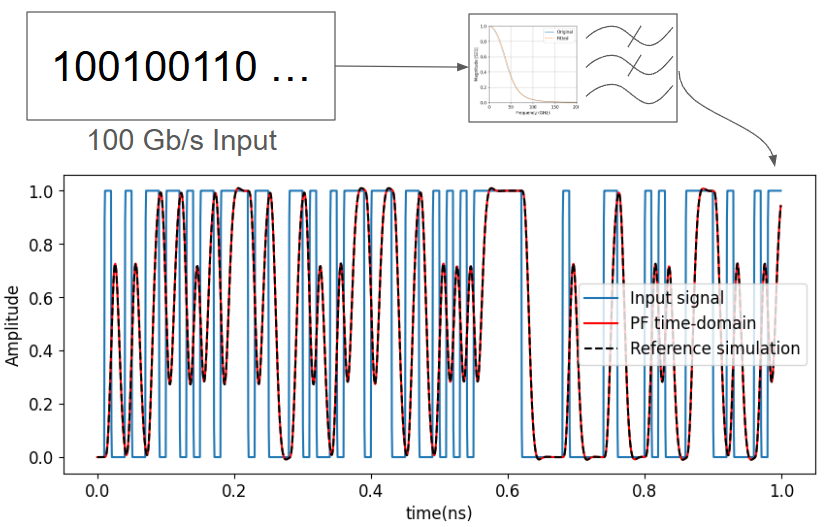

We start by importing the frequency-domain S-parameters of the filter and converting them into an S-matrix representation. This is followed by fitting the frequency response using a pole-residue expansion, which enables efficient and accurate time-domain simulation. Finally, we drive the system using a reference input waveform and compare the resulting output with the response from a commercial simulation tool.


In [1]:
# !pip install scikit-rf # Uncomment this line to install skrf module
import matplotlib.pyplot as plt
import numpy as np
import photonforge as pf
import skrf as rf

plt.rcParams["font.size"] = 12

We begin by importing the frequency-domain response of a low-pass filter from a [touchstone file](../examples/LPF_Time_Domain_Data_Files.zip), which was generated using a commercial electromagnetic solver. The S-parameters are then processed to extract the transmission coefficient (S21) for subsequent time-domain analysis.

In [2]:
# Load the S-parameter data from a commercial EM solver
lpf = rf.Network("sparameters_lpf_30GHz.s1p")

# Extract the frequency vector
freq = lpf.f

# Extract and flatten the S21 parameter 
S21 = lpf.s.squeeze()

We now load the time-domain [input and output](../examples/LPF_Time_Domain_Data_Files.zip) waveforms from a reference simulation performed in a commercial software. The data is read from text files where each row represents a time-value pair, and the first line (header) is skipped.


In [3]:
# Load results from interconnect simulations
filenames = ["input_signal.txt", "output_signal.txt"]

# Read txt files while skipping the first row (header)
data = [np.loadtxt(filename, delimiter=",", skiprows=1) for filename in filenames]

# Extract time vector and signal waveforms
time = data[0][:, 0]  # Time
input_signal = data[0][:, 1]  # Input signal amplitude
output_signal = data[1][:, 1]  # Output signal amplitude

## Creating the S-Matrix

To reproduce the time-domain response within PhotonForge, we first define an [S-matrix](../_autosummary/photonforge.SMatrix.rst) using the imported frequency-domain data. This S-matrix encapsulates the S21 transmission response of the low-pass filter and serves as the foundation for time-domain simulation.


In [4]:
elements = {("1", "2"): S21}
baseband_freqs = freq
s_matrix = pf.SMatrix(frequencies=baseband_freqs, elements=elements)

### Fitting the S-Matrix

To enable time-domain simulation, we fit the frequency-domain S-matrix using a rational function approximation via pole-residue expansion. We specify a frequency-dependent delay and control the fitting accuracy using an RMS error tolerance. The fitted response is then compared against the original S21 to validate the quality of the approximation.


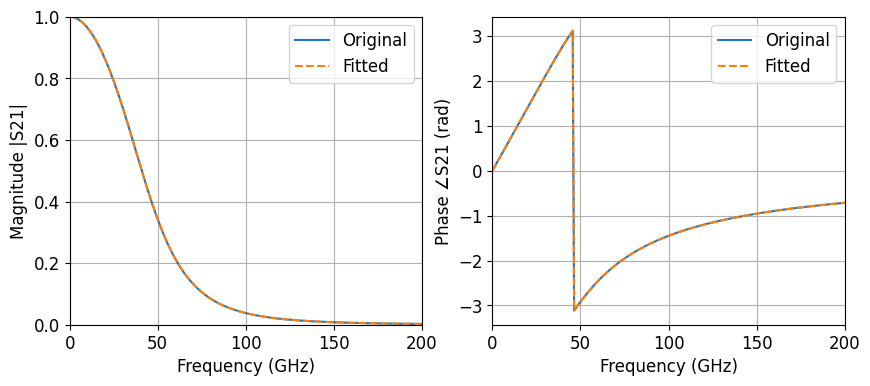

In [5]:
# Fit the S-matrix using a pole-residue model for time-domain simulation
pole_res, err = pf.pole_residue_fit(s_matrix, min_poles=4)

# Evaluate the fitted S21 over the original frequency range
S21_fit = pole_res(baseband_freqs)[("1", "2")]

# Plot magnitude and phase comparison of original vs fitted response
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot magnitude
ax[0].plot(freq / 1e9, np.abs(S21), label="Original")
ax[0].plot(freq / 1e9, np.abs(S21_fit), "--", label="Fitted")
ax[0].set_xlabel("Frequency (GHz)")
ax[0].set_ylabel("Magnitude |S21|")
ax[0].set_xlim(0, 200)
ax[0].set_ylim(0, 1)
ax[0].legend()
ax[0].grid(True)

# Plot phase
ax[1].plot(freq / 1e9, np.angle(S21), label="Original")
ax[1].plot(freq / 1e9, np.angle(S21_fit), "--", label="Fitted")
ax[1].set_xlabel("Frequency (GHz)")
ax[1].set_ylabel("Phase ∠S21 (rad)")
ax[1].set_xlim(0, 200)
ax[1].legend()
ax[1].grid(True)

## Time-Domain Response

With the fitted pole-residue model, we simulate the time-domain behavior of the low-pass filter in PhotonForge. The simulation is driven by the input signal from the reference environment, and the result is compared with the original output waveform. This demonstrates the accuracy of PhotonForge’s time-domain engine in reproducing realistic filter responses.


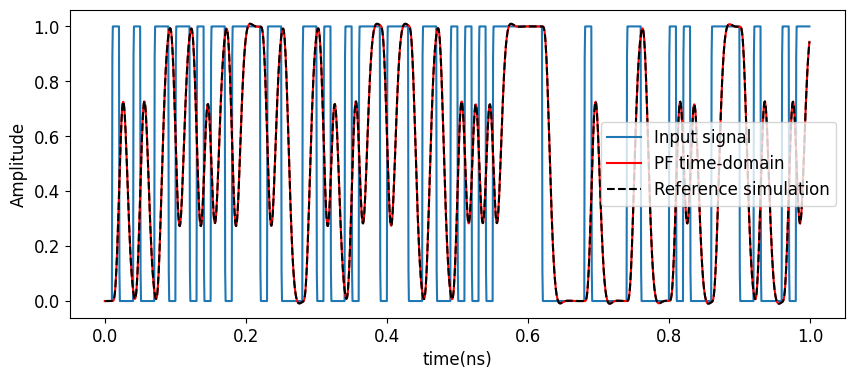

In [6]:
# Set up time and sampling step
t = time
dt = t[1] - t[0]

# Create a time-domain model from the fitted pole-residue system
time_domain_model = pf.TimeDomainModel(pole_res, time_step=dt)

# Simulate time-domain response by stepping through input waveform
received_signal = np.zeros(len(t), dtype=complex)
for i in range(len(t)):
    received_signal[i] = np.real(
        time_domain_model.step(inputs={"1": input_signal[i]})["2"]
    )

# Convert to real to avoid ComplexWarning during plotting
received_signal = np.real(received_signal)

# Plot input and output signals for comparison
%matplotlib inline
plt.figure(figsize=(10, 4))
plt.plot(t[:5000] * 1e9, input_signal[:5000], label="Input signal")           # Original input
plt.plot(t[:5000] * 1e9, received_signal[:5000], "r-", label="PF time-domain")  # PF simulated output
plt.plot(t[:5000] * 1e9, output_signal[:5000], "k--", label="Reference simulation") # Reference simulation output
plt.xlabel("time(ns)")
plt.ylabel("Amplitude")
plt.legend()
